# Домашнее задание № 7 

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import os
import cv2
import skimage
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance
import random

from sklearn.ensemble import AdaBoostClassifier
import joblib

# Поиск объектов в видеопотоке 

Задача - придумать и реализовать алгоритм поиска (обнаружения без классификации) движущихся объектов.

В качестве исходных данных приведена выборка с видеофайлами и аннотацией для каждого кадра файла. Аннотация задана в виде ограничивающих прямоугольников в формате ```(y1,x1,y2,x2)```, где
- ```(x1,y1)``` - верхний левый угол прямоугольника;
- ```(x2,y2)``` - нижний правый угол прямоугольника.

Ссылка на данные – https://disk.yandex.ru/d/RdjMDoQQO8Ngcw

В качестве обучающей можно брать любые видеофайлы. При этом должны быть отдельно выбраны тестовые данные, которые не будут использованы в создании решения. 

Видеофайл с результатами работы алгоритма должен быть прикреплен вместе с решением. Пример фрагмента видеофайла с результатом поиска объектов приведен ниже.

Исходный код может быть в формате ```.py``` или ```.ipynb```.

![annotation](annot_example.gif "annotation")

## Требования к результату
- поиск должен находить геометрические место объекта на видеоизображении. Геометрическое место задано ограничивающим прямоугольником (bounding box);
- продолжительность решения для любого одного видеофайла не должна превышать 10 минут;
- должна быть приведена оценка точности решения;
- привести демонстрацию результатов требется на одном из тестовых видеофайлов.

# Немного функций для личного пользования 

In [2]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [3]:
def draw_points(image, points, rect=0, gray=False, draw=True):
    color1 = (0, 0, 255)
    color2 = (0, 255, 0)
    output = image.copy()
    if gray:
        output = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
        
    for point in points:
        output = cv2.circle(output, point, 3, color1, -1)
    
    if type(rect) != int:
        output = cv2.rectangle(output, rect[0], rect[1], color2)
    
    if draw:
        plot_one_image(output)
    return output

In [4]:
def get_video_details(cap, do_print=True):
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if do_print:
        print(cnt, w, h, fps)
    return cnt, w, h, fps

In [5]:
def get_video(num=-1, file_name="", path='./Videos/Videos/'):
    """
    Функция достающая видео
    num - номер видео (если num == -1, то достаются все видео)
    
    """
    if file_name != "":
        return cv2.VideoCapture(path+file_name)
    
    all_names = os.listdir(path)
    names = []
    for name in all_names:
        if name.endswith(".mov") or name.endswith(".mp4"):
            names.append(name)
            
    if num >= 0:
        print(name)
        name_vid = names[num]
        return cv2.VideoCapture(path+name_vid)
        
        
    videos = []
    for name_vid in names:
        videos.append(cv2.VideoCapture(path+name_vid))
    return videos
    

In [6]:
def create_video(save_dir, size, img_format='jpg', vido_format='avi'):
    out_name = Path(save_dir).parts[-1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(Path(save_dir) / Path(f'{out_name}.{vido_format}')),
                          fourcc, 20, tuple(size.astype(int)))

    for fname in tqdm(sorted(map(str, Path(save_dir).glob(f'*.{img_format}')))):
        imag = skimage.io.imread(fname)
        imag = cv2.cvtColor(imag, cv2.COLOR_RGB2BGR)
        out.write(imag)
    out.release()

In [7]:
def show_video(num=-1,path='./tmp/', sleep=0):
    cap = get_video(num if num >=0 else 0, path=path)
    get_video_details(cap)
    cv2.startWindowThread()
    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
            
        if sleep > 0:
            time.sleep(sleep)

        cv2.imshow("sparse optical flow", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [8]:
def save_clf(clf, filename='./clf.joblib.pkl'):
    joblib.dump(clf, filename, compress=9)
    
def load_clf(filename='./clf.joblib.pkl'):
    return joblib.load(filename)

# Классы для загрузки анатации 
(что-то там не нужно, но раз сделано, то зачем удалять)

In [9]:
class AnnotationRect:
    def __init__(self, i, point1=None, point2=None):
        self.i = i
        self.x1 = point1[0] if point1 != None else -1 
        self.y1 = point1[1] if point1 != None else -1 
        self.x2 = point2[0] if point2 != None else -1 
        self.y2 = point2[1] if point2 != None else -1 
        
    def get_w(self):
        return self.x2 - self.x1

    def get_h(self):
        return self.y2 - self.y1
    
    def get_point1(self):
        return np.array([self.x1, self.y1])
    
    def get_point2(self):
        return np.array([self.x2, self.y2])
    
    def get_center(self):
        return (self.get_point1() + self.get_point2())//2
    
    def set_point1(self, point):
        self.x1 = point[0] 
        self.y1 = point[1]  
        
    def set_point2(self, point):
        self.x2 = point[0] 
        self.y2 = point[1]
        
    def is_there(self):
        return not(self.x1 == -1)

In [10]:
class Annotation:
    def get_annotation(self, file_name, path='./Videos/Annotation/'):
        f = open(path+file_name, 'r')
        
        self.annotation = []
        for string in f:
            l = string.split()
            self.annotation.append(AnnotationRect(l[1]))
            if len(l) > 3:
                self.annotation[-1].set_point1([int(l[4][:-1]), int(l[3][1:-1])])
                self.annotation[-1].set_point2([int(l[6][:-2]), int(l[5][:-1])])

        return self.annotation
    
    def show_annotation(cap, sleep=0):
        color = (0, 255, 0)
        cv2.startWindowThread()

        i = 0
        while (cap.isOpened()):
            is_ok, frame = cap.read()
            if not is_ok:
                break

            if sleep > 0:
                time.sleep(sleep)

            hsv_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2HSV)
            frame = cv2.rectangle(frame, self.annotation[i].get_point1(), self.annotation[i].get_point2(), color)

            cv2.imshow("sparse optical flow", frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            i += 1

        cap.release()
        cv2.destroyAllWindows()
        
    def get_annotation_rect(self, idx):
        return self.annotation[idx]
    
    def has_target(self, idx):
        return self.annotation[idx].is_there()
    
    def get_max_annotation_rect_size(self):
        max_w = max([rect.get_w() for rect in self.annotation])
        max_h = max([rect.get_h() for rect in self.annotation])
        return max_w, max_h

# Функции для поиска хороших для обработки точек
Все работает через границы
</p>Количество точек уменьшается за счет установки минимального расстояния между ними
</p></p> PS: эта функция используется как при тренировке классификатора, так и для обработки видио, так что принимает классификатор (clf), как параметр с None по умолчанию
</p></p>PS2: число 0.513 подобрано, я без понятия, почему он так плохо видит модельку, так как если поставить хотя бы 0.52 то он скажет что ничего нет, а если поставить меньше, то он все облака возьмет примет за самолет

In [11]:
def get_border_mask(gray):
    temp = cv2.GaussianBlur(gray, (5,5), 0)
    kernel = np.ones((3, 3), np.uint8)
    mask = skimage.feature.canny(gray, sigma=0.5)
    return mask

In [12]:
def point_in_rect(rect_points, point):
    p1, p2 = rect_points
    return np.all(point >= p1) and np.all(point <= p2)

In [13]:
def get_good_points(frame, min_dist=20, clf=None, len_side=None):
    h, w, _ = frame.shape
    hsv_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    
    res_mask = get_border_mask(gray)
    not_green_mask = hsv_frame[:,:,0] > 100
    res_mask &= not_green_mask
    
    stick_mask = np.ones(gray.shape).astype(bool)
    stick_mask[h*20//40: h*28//40+1, 0:w*15//90+1] = 0
    res_mask &= stick_mask
    
    edge_mask = np.ones(gray.shape).astype(bool)
    edge_mask[0:min_dist+1, :] = 0
    edge_mask[:, 0:min_dist+1] = 0
    edge_mask[h-min_dist-2:, :] = 0
    edge_mask[:, w-min_dist-2:] = 0
    res_mask &= edge_mask
    
    p = np.where(res_mask > 0)
    y = p[0]
    x = p[1]
    all_points = np.array(list(zip(x, y)))
    
    points = np.array([all_points[0]])
    
    for point in all_points:
        if np.min(np.abs(points[:,0] - point[0]) + np.abs(points[:,1] - point[1])) > min_dist//2:
            points = np.r_[points, [point]] 
    
    if clf:
        points_slice = []
        for point in points:
            points_slice.append(frame[point[1]-len_side//2: point[1]+len_side//2+1, 
                                        point[0]-len_side//2: point[0]+len_side//2+1].ravel())
        points_slice = np.array(points_slice)
        target = clf.predict_proba(points_slice)
        target = target[:,1] > 0.513
        points = points[target]
    
    points = np.array([np.float32(point) for point in points])
    return points

# Функции для создания и тренировки классификатора
Использован AdaBoostClassifier, почему не скажу (первое что пришло в голову)

In [14]:
def get_train_data(names_vid, names_ann, max_idx=-1):
    file_names_vid = []
    if type(names_vid) != list:
        file_names_vid = [names_vid]
    else:
        file_names_vid = names_vid
    
    file_names_ann = []
    if type(names_ann) != list:
        file_names_ann = [names_ann]
    else:
        file_names_ann = names_ann
        
    all_time = []
    targets_slices = []
    other_slices = []
    annotations = []
    len_side = 0
    for i, name_ann in enumerate(file_names_ann):
        annotations.append(Annotation())
        annotations[-1].get_annotation(name_ann)
        an_w, an_h = annotations[-1].get_max_annotation_rect_size()
        temp = max(an_w,an_h)
        len_side = temp if len_side<temp else len_side
        
    for i, annotation in enumerate(annotations):
        cap = get_video(file_name=file_names_vid[i])
        cnt, w, h, fps = get_video_details(cap)
        cnt = int(cnt)
        
        for idx in tqdm(range(cnt)):
            if not cap.isOpened():
                break
            if max_idx > 0 and idx > max_idx:
                break

            is_ok, frame = cap.read()
            if not is_ok:
                break

            gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)

            if annotation.has_target(idx):
                t1 = time.time()
                prev = get_good_points(frame, min_dist=len_side//2)

                center_points = np.array([np.int32(point) for point in prev])
                t2 = time.time()

                target_points = []
                other_points = []
                rect = annotation.get_annotation_rect(idx)

                for i, point in enumerate(center_points):
                    add_r = np.array([2,2])
                    if point_in_rect([rect.get_point1()-add_r, rect.get_point2()+add_r], point):
                        target_points.append(point)
                    else:
                        other_points.append(point)

                for point in target_points:
                    targets_slices.append(frame[point[1]-len_side//2: point[1]+len_side//2+1, 
                                               point[0]-len_side//2: point[0]+len_side//2+1].ravel())

                other_points = random.choices(other_points, k=len(target_points))
                for point in other_points:
                    other_slices.append(frame[point[1]-len_side//2: point[1]+len_side//2+1, 
                                             point[0]-len_side//2: point[0]+len_side//2+1].ravel())
                t3 = time.time()
                all_time.append(t3-t1)
            else:
                all_time.append(0)
             
    len_side = (len_side//2)*2+1
    return targets_slices, other_slices, len_side, all_time

In [15]:
def train_model(targets_slices, other_slices, len_side): 
    print('len target', len(targets_slices))
    print('len other', len(other_slices)) 
    
    count = len(targets_slices)
    
    targets_slices = np.array(targets_slices)
    other_slices = np.array(other_slices)
    
    X = np.r_[targets_slices, other_slices]
    y = np.zeros(count*2)
    y[:count+1] = 1

    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(X, y)
    
    return clf

### Этот код запускать не нужно, если есть файл с сохраненным классификатором 
(надеюсь он работает, я просто его запускал только 1 раз) 

In [16]:
# targets_slices, other_slices, len_side, all_time = get_train_data(['Clip_6.mov', 'Clip_7.mov', 
#                                                                    'Clip_8.mov', 'Clip_9.mov'],
#                                                                   ['Clip_6_gt.txt', 'Clip_7_gt.txt', 
#                                                                    'Clip_8_gt.txt', 'Clip_9_gt.txt'], 
#                                                                   max_idx=-1)
# model = train_model(targets_slices, other_slices, len_side)
# save_clf(model)

# Функция поиска самолетика

In [17]:
def get_len_side(names_vid, names_ann):
    file_names_vid = []
    if type(names_vid) != list:
        file_names_vid = [names_vid]
    else:
        file_names_vid = names_vid
    
    file_names_ann = []
    if type(names_ann) != list:
        file_names_ann = [names_ann]
    else:
        file_names_ann = names_ann
        
    len_side = 0
    for i, name_ann in enumerate(file_names_ann):
        annotation = Annotation()
        annotation.get_annotation(name_ann)
        an_w, an_h = annotation.get_max_annotation_rect_size()
        temp = max(an_w,an_h)
        len_side = temp if len_side<temp else len_side
    
    return len_side

In [18]:
def get_trajectory(cap, model, len_side, max_idx=-1, path='tmp/'):
    cnt, w, h, fps = get_video_details(cap)
    cnt = int(cnt)
    color = (0, 255, 0)
    all_time = []
    for idx in tqdm(range(cnt)):
        if not cap.isOpened():
            break
        if max_idx > 0 and idx > max_idx:
            break
        is_ok, frame = cap.read()
        if not is_ok:
            break
        
        t1 = time.time()
        
        prev = get_good_points(frame.copy(), min_dist=len_side//2, clf=model, len_side=len_side)
        if len(prev) == 0:
            cv2.imwrite(f'tmp/frame_{str(idx).zfill(4)}.jpg', frame.copy())
            continue
            
        points = np.array([point.astype(np.int32) for point in prev])
        good_points = points.copy()
        if len(points) > 1:
            dists = distance.cdist(points, points, 'euclidean')
            np.fill_diagonal(dists, 2*len_side)
            good_points = points[np.any(dists < len_side, axis=1)]
            
        center = good_points.mean(axis=0)
        center = np.int32(center)
        rect_point1 = center - len_side//2
        rect_point2 = center + len_side//2
        output = draw_points(frame.copy(), [], [rect_point1, rect_point2], draw=False)
 
        cv2.imwrite(f'{path}frame_{str(idx).zfill(4)}.jpg', output.copy())
        t2 = time.time() 
        all_time.append(t2-t1)
    cap.release()
    return all_time

200 - количество кадров для обработки ( ~~дальше просто все неособо~~  просто, чтобы время не тратить) 
</p> load_clf загрузит классификатор из файла

In [19]:
model = load_clf()
len_side = get_len_side(['Clip_6.mov', 'Clip_7.mov','Clip_8.mov', 'Clip_9.mov'],
                        ['Clip_6_gt.txt', 'Clip_7_gt.txt', 'Clip_8_gt.txt', 'Clip_9_gt.txt'])
cap = get_video(file_name='Clip_5.mov')
all_time = get_trajectory(cap, model, len_side, 200)

1800.0 1920.0 1080.0 29.97


 11%|████████▊                                                                      | 201/1800 [06:54<54:53,  2.06s/it]


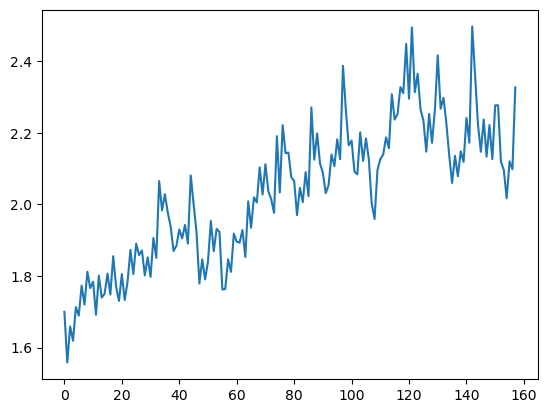

In [20]:
plt.plot(all_time)

In [21]:
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:09<00:00, 21.93it/s]


In [22]:
show_video(sleep=0.1)

tmp.mp4
201.0 1920.0 1080.0 20.0


Ну в общем, что-то хорошее получилось